# Fetching data from CO-OPS SOS with Python tools

[Pyoos](https://github.com/ioos/pyoos) is a high level data collection library for met/ocean data publicly available through many different websites and webservices.

In this post we will use `pyoos` to find
and download data from the [Center for Operational Oceanographic Products and Services (CO-OPS)](http://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/) using OGC's SOS.


- OGC: [Open Geospatial Consortium](http://www.opengeospatial.org/)
- SOS: [Sensor Observation Service](http://www.opengeospatial.org/standards/sos)

First we have to define a time span.
Here we will fetch data during the [hurricane Matthew](https://en.wikipedia.org/wiki/Hurricane_Matthew) passage over the southeast states from 2016-10-05 to 2016-10-12.

(This notebook uses a custom `ioos_tools` module that needs to be added to the path separately. We recommend cloning the [repository](https://github.com/ioos/notebooks_demos) on GitHub which already includes the most update version of `ioos_tools`.)

In [1]:
from datetime import datetime, timedelta

event_date = datetime(2016, 10, 9)

start_time = event_date - timedelta(days=4)
end_time = event_date + timedelta(days=3)

The geographical bounding box includes all the states in the [SECOORA](http://secoora.org/) region: Florida, Georgia, South and North Carolina.

The variable of choice is sea level and we will convert any elevation units to `meters`.

In [2]:
import cf_units

units = cf_units.Unit('meters')

bbox = [-87.40, 24.25, -74.70, 36.70]

sos_name = 'water_surface_height_above_reference_datum'

In this example we will use only the `CoopsSos`,
but it is worth mentioning that `pyoos` has other collectors like IOOS SWE,
NcSOS, 52N, NERRS, NDBC, etc.

Pyoos' usage is quite simple, all we have to do is:

- create an instance of the collector we will use and,
- feed the instance with the data for the collection.

In [3]:
from pyoos.collectors.coops.coops_sos import CoopsSos

collector = CoopsSos()

collector.set_bbox(bbox)
collector.end_time = end_time
collector.start_time = start_time
collector.variables = [sos_name]

Let's check we we got with the search above.

In [4]:
ofrs = collector.server.offerings
title = collector.server.identification.title

print('Collector offerings')
print('{}: {} offerings'.format(title, len(ofrs)))

Collector offerings
NOAA.NOS.CO-OPS SOS: 1142 offerings


OK... That is quite misleading. We did not find 1113 stations with that search.

That number is probably all the CO-OPS SOS stations available.

In order to find out what we really get from that search we need to download the data. In the next two cells we will use a custom function to go from the collector object to a list of observations and a pandas `DataFrame` with all the data.

(Check the code for [`collector2table`](http://bit.ly/2eiUozm) for the implementation details.)

In [5]:
import os
import sys

ioos_tools = os.path.join(os.path.pardir)
sys.path.append(ioos_tools)

In [6]:
import pandas as pd
from ioos_tools.ioos import collector2table

config = dict(
    units=units,
    sos_name=sos_name,
)

data = collector2table(
    collector=collector,
    config=config,
    col='water_surface_height_above_reference_datum (m)'
)

# Clean the table.
table = dict(
    station_name=[s._metadata.get('station_name') for s in data],
    station_code=[s._metadata.get('station_code') for s in data],
    sensor=[s._metadata.get('sensor') for s in data],
    lon=[s._metadata.get('lon') for s in data],
    lat=[s._metadata.get('lat') for s in data],
    depth=[s._metadata.get('depth') for s in data],
)

table = pd.DataFrame(table).set_index('station_name')

table

,depth,lat,lon,sensor,station_code
station_name,,,,,
"Duck, NC",None,36.1833,-75.7467,urn:ioos:sensor:NOAA.NOS.CO-OPS:8651370:A1,8651370
"Oregon Inlet Marina, NC",None,35.7950,-75.5481,urn:ioos:sensor:NOAA.NOS.CO-OPS:8652587:A1,8652587
"USCG Station Hatteras, NC",None,35.2086,-75.7042,urn:ioos:sensor:NOAA.NOS.CO-OPS:8654467:A1,8654467
"Beaufort, NC",None,34.7200,-76.6700,urn:ioos:sensor:NOAA.NOS.CO-OPS:8656483:A1,8656483
"Wilmington, NC",None,34.2275,-77.9536,urn:ioos:sensor:NOAA.NOS.CO-OPS:8658120:B1,8658120
"Wrightsville Beach, NC",None,34.2133,-77.7867,urn:ioos:sensor:NOAA.NOS.CO-OPS:8658163:A1,8658163
"Springmaid Pier, SC",None,33.6550,-78.9183,urn:ioos:sensor:NOAA.NOS.CO-OPS:8661070:Y1,8661070
"Oyster Landing (N Inlet Estuary), SC",None,33.3517,-79.1867,urn:ioos:sensor:NOAA.NOS.CO-OPS:8662245:A1,8662245
"Charleston, Cooper River Entrance, SC",None,32.7808,-79.9236,urn:ioos:sensor:NOAA.NOS.CO-OPS:8665530:A1,8665530


In the next cell we will re-sample all the observation from CO-OPS' original frequency (6 minutes) to 15 minutes to reduce the amount of data and hopefully some of the noise too.

In [7]:
index = pd.date_range(start=start_time.replace(tzinfo=None),
                      end=end_time.replace(tzinfo=None),
                      freq='15min')

# Re-index and rename series.
observations = []
for series in data:
    _metadata = series._metadata
    obs = series.reindex(index=index, limit=1, method='nearest')
    obs._metadata = _metadata
    obs.name = _metadata['station_name']
    observations.append(obs)

We can now check the station with the highest sea elevation.

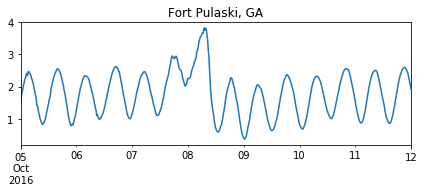

In [8]:
%matplotlib inline

df = pd.DataFrame(observations).T

station = df.max(axis=0).idxmax()

ax = df[station].plot(figsize=(7, 2.25))
title = ax.set_title(station)

Oops. That does not look right! The data are near-real time,
so some QA/QC may be needed before we move forward.

We can filter spikes with a simple first difference rule.

(Check the code for [`first_difference`](http://bit.ly/2fAtuos) for the implementation details.)

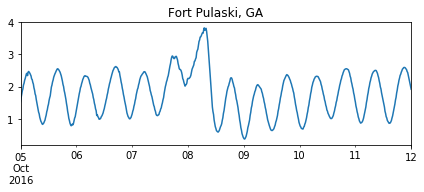

In [9]:
from ioos_tools.qaqc import first_difference

mask = df.apply(first_difference, args=(0.99,))

df = df[~mask].interpolate()

ax = df[station].plot(figsize=(7, 2.25))
title = ax.set_title(station)

That is much better!
Now we can plot the station that actually registered the highest sea elevation.

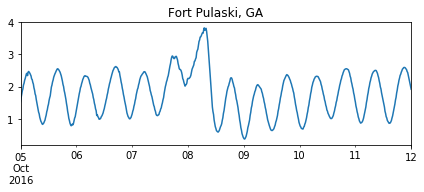

In [10]:
station = df.max(axis=0).idxmax()

ax = df[station].plot(figsize=(7, 2.25))
title = ax.set_title(station)

Let's plot the last 5 stations, from North Carolina, so we can compare with Fort Pulaski, GA.

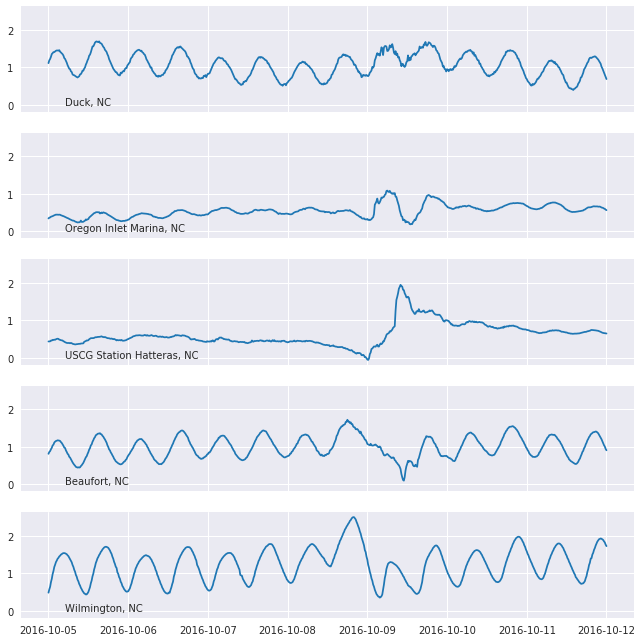

In [11]:
import matplotlib
import matplotlib.pyplot as plt

with matplotlib.style.context(['seaborn-notebook', 'seaborn-darkgrid']):
    fix, axes = plt.subplots(nrows=5, sharex=True, sharey=True, figsize=(11, 2.25*5))

    for k, obs in enumerate(observations[:5]):
        axes[k].plot(obs.index, obs.values)
        axes[k].text(obs.index[20], 0, obs._metadata['station_name'])

Ideally we should filter out the tides in order to better interpret the storm surges.
We'll leave that as an exercise to the readers.

In order to easily explore all the stations we can put together an interactive map with the stations positions and the elevation time-series.
This can be done using the software package `bokeh` and the mapping library `folium`.

In [12]:
from bokeh.resources import CDN
from bokeh.plotting import figure
from bokeh.embed import file_html

from folium import IFrame

# Plot defaults.
tools = "pan,box_zoom,reset"
width, height = 750, 250


def make_plot(series):
    p = figure(toolbar_location="above",
               x_axis_type="datetime",
               width=width,
               height=height,
               tools=tools,
               title=series.name)
    line = p.line(
        x=series.index,
        y=series.values,
        line_width=5,
        line_cap='round',
        line_join='round'
    )
    return p, line


def make_marker(p, location, fname):
    html = file_html(p, CDN, fname)
    iframe = IFrame(html, width=width+45, height=height+80)

    popup = folium.Popup(iframe, max_width=2650)
    icon = folium.Icon(color='green', icon='stats')
    marker = folium.Marker(location=location,
                           popup=popup,
                           icon=icon)
    return marker

In [13]:
import folium

lon = (bbox[0]+bbox[2])/2
lat = (bbox[1]+bbox[3])/2

m = folium.Map(location=[lat, lon], tiles='OpenStreetMap', zoom_start=5)

for obs in observations:
    fname = obs._metadata['station_code']
    location = obs._metadata['lat'], obs._metadata['lon']
    p, _ = make_plot(obs)
    marker = make_marker(p, location=location, fname=fname)
    marker.add_to(m)

m